# Student Test Score Prediction - Kaggle Playground Series S6E1

## Competition Overview
- **Goal**: Predict student exam scores from demographic and behavioral features
- **Metric**: RMSE (Root Mean Squared Error)
- **Dataset**: 630,000 training samples, 270,000 test samples
- **Features**: 12 features (4 numerical, 7 categorical)

## Approach
1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Baseline Models (Ridge, Random Forest)
4. Advanced Models (LightGBM, XGBoost, CatBoost)
5. Ensemble Methods
6. Final Submission


## 1. Setup and Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

# ML libraries
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain columns: {list(train.columns)}")
print(f"\nFirst few rows:")
train.head()


Train shape: (630000, 13)
Test shape: (270000, 12)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

First few rows:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [3]:
# Basic data inspection
print("=== Data Types ===")
print(train.dtypes)
print("\n=== Missing Values ===")
print(f"Train: {train.isnull().sum().sum()} missing values")
print(f"Test: {test.isnull().sum().sum()} missing values")
print("\n=== Target Statistics ===")
print(train['exam_score'].describe())


=== Data Types ===
id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

=== Missing Values ===
Train: 0 missing values
Test: 0 missing values

=== Target Statistics ===
count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64


## 2. Exploratory Data Analysis (EDA)


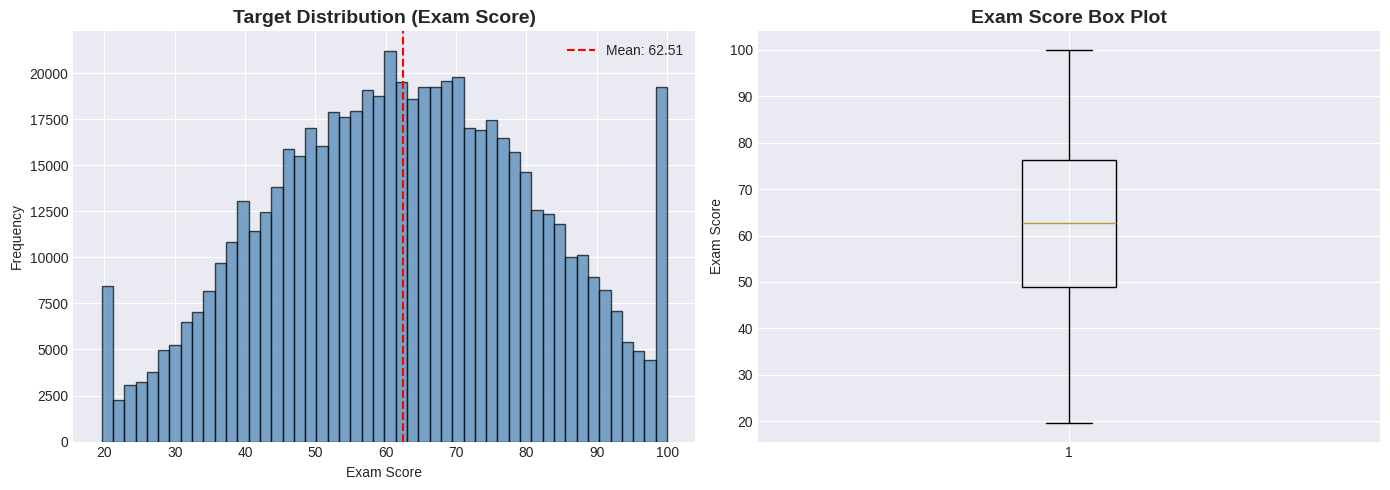

Mean: 62.51
Std: 18.92
Min: 19.60
Max: 100.00
Skewness: -0.048
Kurtosis: -0.619


In [4]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train['exam_score'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_title('Target Distribution (Exam Score)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train['exam_score'].mean(), color='red', linestyle='--', label=f'Mean: {train["exam_score"].mean():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(train['exam_score'], vert=True)
axes[1].set_title('Exam Score Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Exam Score')

plt.tight_layout()
plt.show()

print(f"Mean: {train['exam_score'].mean():.2f}")
print(f"Std: {train['exam_score'].std():.2f}")
print(f"Min: {train['exam_score'].min():.2f}")
print(f"Max: {train['exam_score'].max():.2f}")
print(f"Skewness: {stats.skew(train['exam_score']):.3f}")
print(f"Kurtosis: {stats.kurtosis(train['exam_score']):.3f}")


In [5]:
# Identify feature types
numerical_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
categorical_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 
                   'study_method', 'facility_rating', 'exam_difficulty']

print(f"Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")


Numerical features (4): ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical features (7): ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


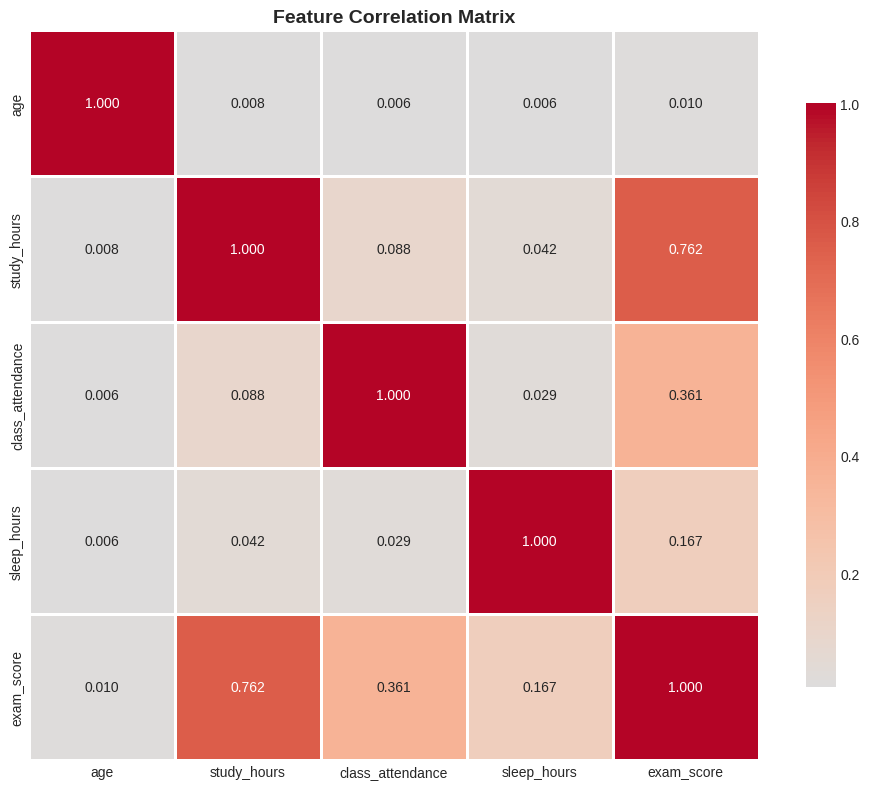


Top correlations with exam_score:
  study_hours         : 0.7623
  class_attendance    : 0.3610
  sleep_hours         : 0.1674
  age                 : 0.0105


In [6]:
# Correlation matrix for numerical features
correlation_data = train[numerical_cols + ['exam_score']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop correlations with exam_score:")
target_corr = correlation_data['exam_score'].drop('exam_score').abs().sort_values(ascending=False)
for feat, corr in target_corr.items():
    print(f"  {feat:20s}: {corr:.4f}")


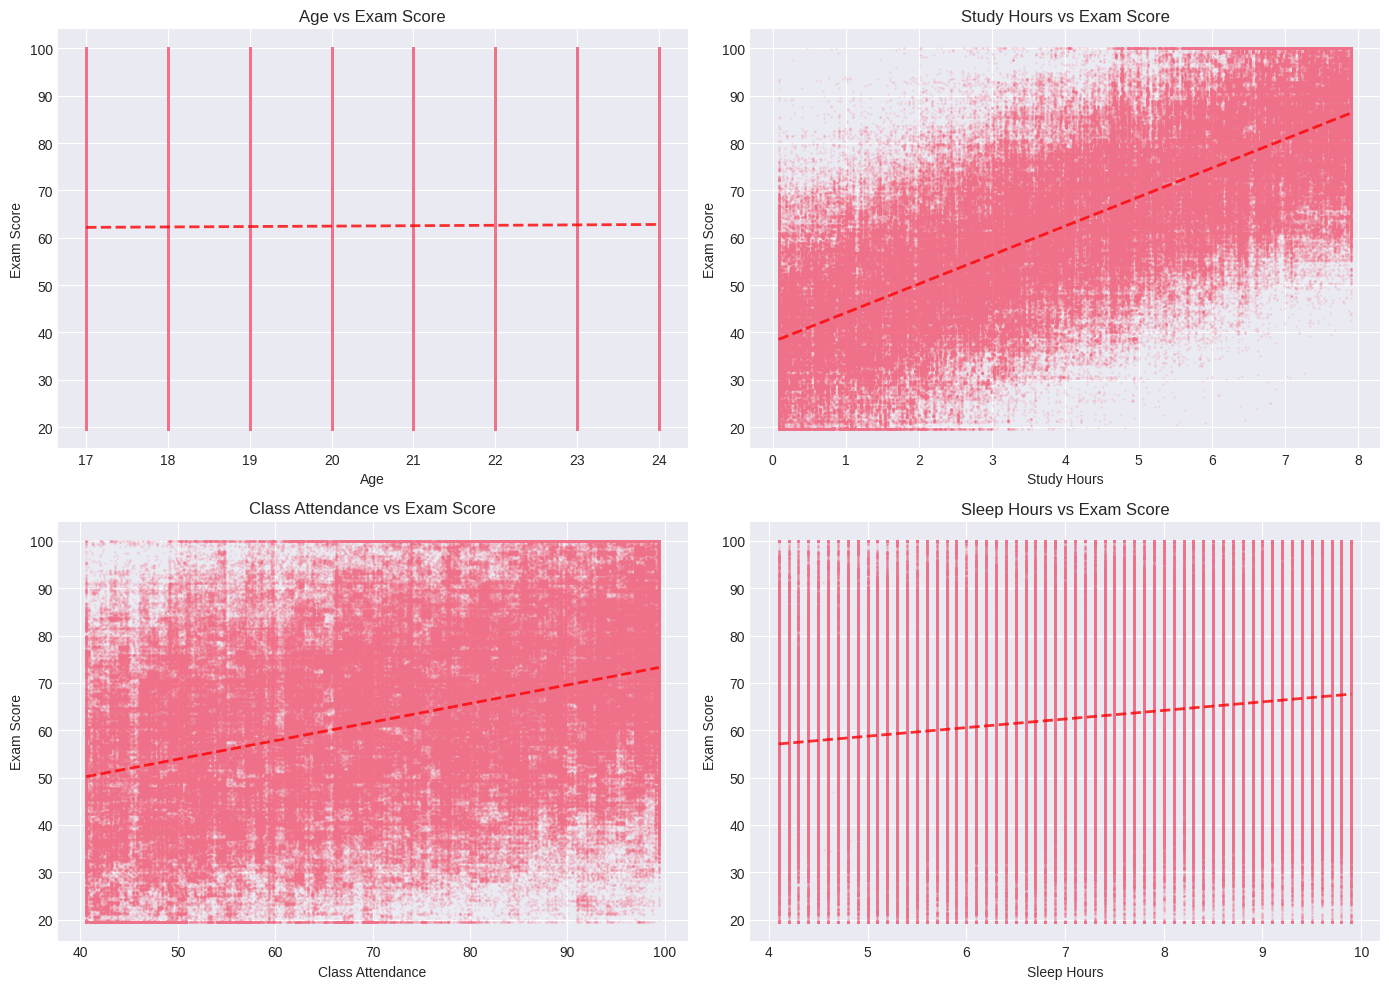

In [7]:
# Scatter plots: key numerical features vs exam_score
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    axes[idx].scatter(train[col], train['exam_score'], alpha=0.1, s=1)
    axes[idx].set_xlabel(col.replace('_', ' ').title())
    axes[idx].set_ylabel('Exam Score')
    axes[idx].set_title(f'{col.replace("_", " ").title()} vs Exam Score')
    
    # Add trend line
    z = np.polyfit(train[col], train['exam_score'], 1)
    p = np.poly1d(z)
    axes[idx].plot(train[col].sort_values(), p(train[col].sort_values()), 
                   "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()


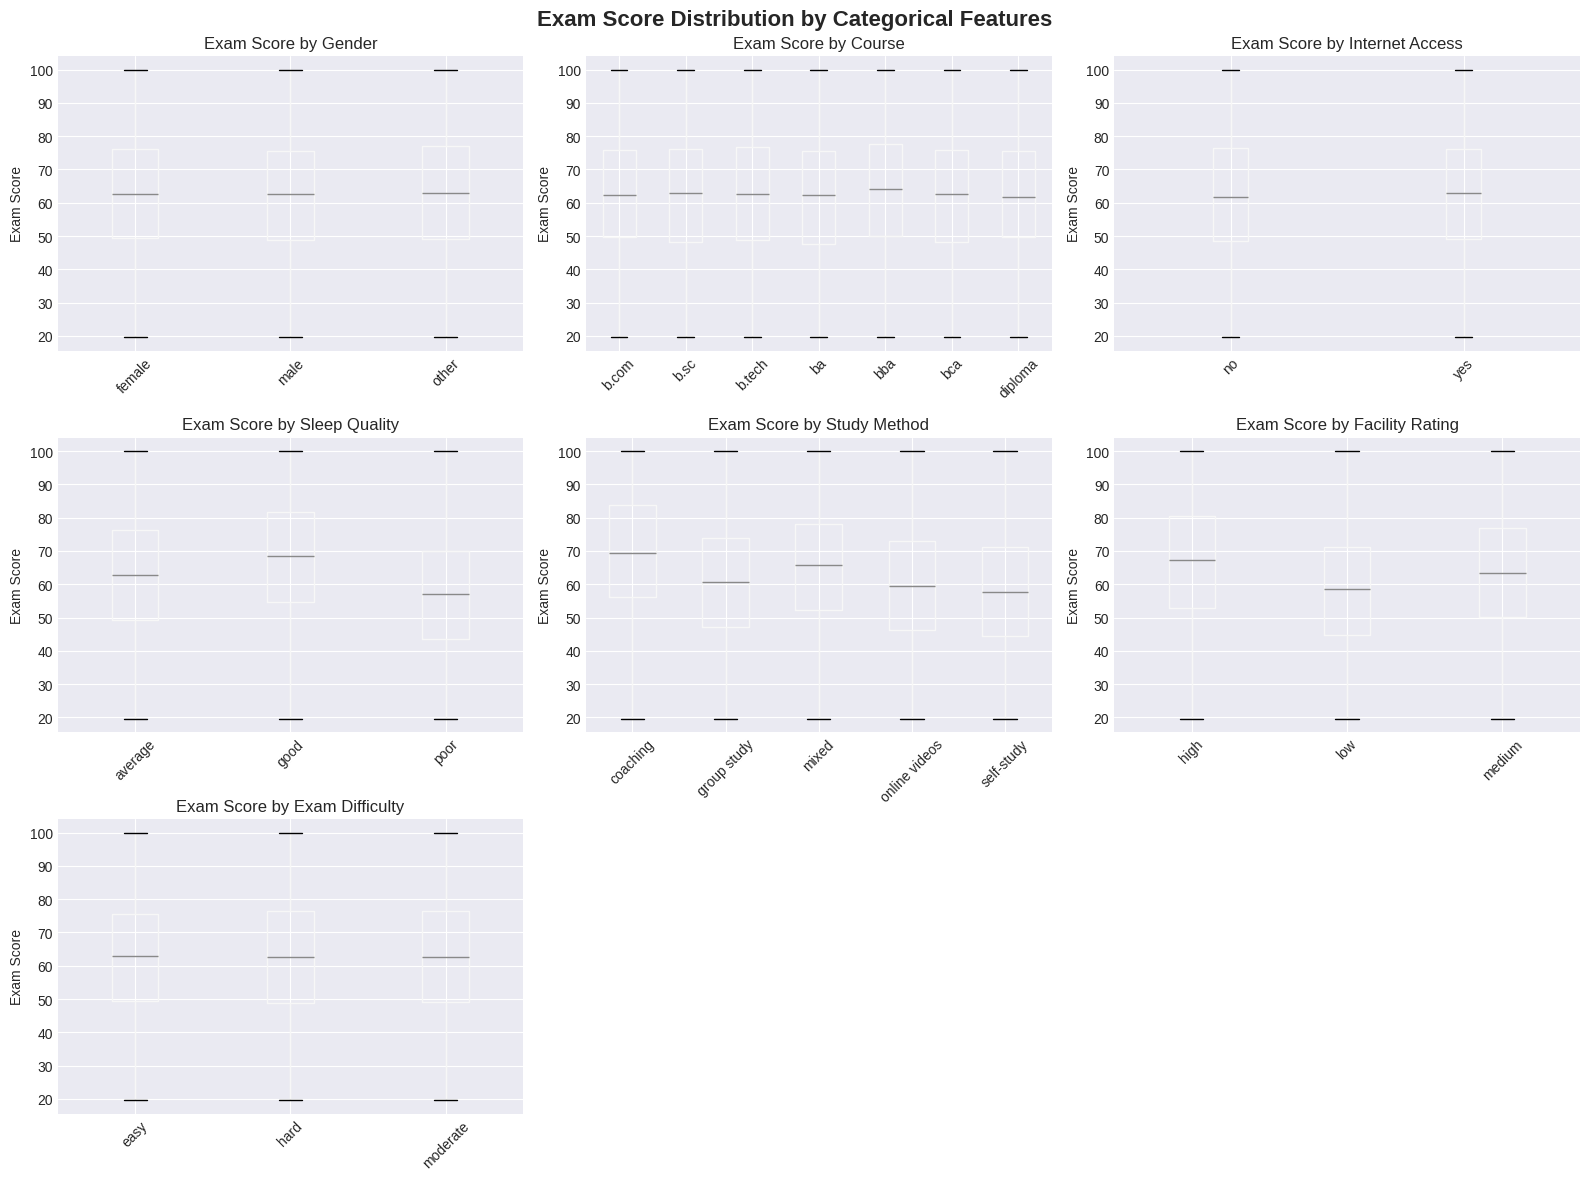

In [8]:
# Boxplots: categorical features vs exam_score
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    # Sample data for faster plotting
    sample_data = train.sample(n=min(50000, len(train)), random_state=SEED)
    sample_data.boxplot(column='exam_score', by=col, ax=axes[idx])
    axes[idx].set_title(f'Exam Score by {col.replace("_", " ").title()}')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Exam Score')
    plt.sca(axes[idx])
    plt.xticks(rotation=45)

# Remove extra subplots
for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Exam Score Distribution by Categorical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Feature Engineering


In [9]:
# Store original train/test for later use
train_original = train.copy()
test_original = test.copy()

# Store IDs and target
train_ids = train['id'].copy()
test_ids = test['id'].copy()
target = train['exam_score'].copy()

print("Data backed up successfully!")


Data backed up successfully!


In [10]:
# Feature engineering function
def create_interaction_features(df):
    """Create interaction and derived features"""
    df = df.copy()
    
    # Interaction features
    df['study_attendance'] = df['study_hours'] * df['class_attendance']
    df['study_sleep'] = df['study_hours'] * df['sleep_hours']
    df['attendance_sleep'] = df['class_attendance'] * df['sleep_hours']
    df['age_study'] = df['age'] * df['study_hours']
    
    # Ratio features
    df['attendance_per_hour'] = df['class_attendance'] / (df['study_hours'] + 0.001)
    df['sleep_per_study'] = df['sleep_hours'] / (df['study_hours'] + 0.001)
    
    # Polynomial features
    df['study_hours_sq'] = df['study_hours'] ** 2
    df['study_hours_cb'] = df['study_hours'] ** 3
    df['class_attendance_sq'] = df['class_attendance'] ** 2
    df['sleep_hours_sq'] = df['sleep_hours'] ** 2
    
    # Square root features
    df['study_hours_sqrt'] = np.sqrt(df['study_hours'])
    df['class_attendance_sqrt'] = np.sqrt(df['class_attendance'])
    
    # Binary flags
    df['is_low_sleep'] = (df['sleep_hours'] < 6).astype(int)
    df['is_high_attendance'] = (df['class_attendance'] > 80).astype(int)
    df['is_high_study'] = (df['study_hours'] > 6).astype(int)
    
    # Domain knowledge formula (from Kaggle discussion)
    df['formula_score'] = (6.0 * df['study_hours'] + 
                           0.35 * df['class_attendance'] + 
                           1.5 * df['sleep_hours'])
    
    # Binning features
    df['study_hours_bin'] = pd.cut(df['study_hours'], bins=5, labels=False)
    df['class_attendance_bin'] = pd.cut(df['class_attendance'], bins=5, labels=False)
    df['sleep_hours_bin'] = pd.cut(df['sleep_hours'], bins=5, labels=False)
    
    return df

print("Feature engineering function defined!")


Feature engineering function defined!


In [11]:
# Apply interaction features
train_fe = create_interaction_features(train)
test_fe = create_interaction_features(test)

print(f"Original train shape: {train.shape}")
print(f"After feature engineering: {train_fe.shape}")
print(f"Added {train_fe.shape[1] - train.shape[1]} new features")


Original train shape: (630000, 13)
After feature engineering: (630000, 32)
Added 19 new features


In [12]:
# Label encoding for categorical features
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_fe[col] = le.fit_transform(train_fe[col].astype(str))
    label_encoders[col] = le
    
    # Transform test set
    test_fe[col] = test_fe[col].astype(str).map(
        {label: idx for idx, label in enumerate(le.classes_)}
    ).fillna(-1).astype(int)

print("Label encoding completed!")


Label encoding completed!


In [13]:
# Target encoding (CV-safe)
def target_encode_cv_safe(train_df, test_df, cat_cols, target_col, n_folds=5):
    """Target encoding with cross-validation to prevent leakage"""
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    
    for col in cat_cols:
        # Initialize with global mean
        global_mean = train_df[target_col].mean()
        train_encoded[f'{col}_target_enc'] = global_mean
        
        # Encode train with CV
        for train_idx, val_idx in kf.split(train_df):
            target_mean = train_df.iloc[train_idx].groupby(col)[target_col].mean()
            train_encoded.loc[val_idx, f'{col}_target_enc'] = \
                train_df.iloc[val_idx][col].map(target_mean).fillna(global_mean)
        
        # Encode test using full train
        target_mean = train_df.groupby(col)[target_col].mean()
        test_encoded[f'{col}_target_enc'] = test_df[col].map(target_mean).fillna(global_mean)
    
    return train_encoded, test_encoded

print("Target encoding function defined!")


Target encoding function defined!


In [14]:
# Apply target encoding
train_fe, test_fe = target_encode_cv_safe(
    train_fe, test_fe, categorical_cols, 'exam_score', n_folds=5
)

print(f"Shape after target encoding: {train_fe.shape}")
print(f"New target-encoded features: {[col for col in train_fe.columns if 'target_enc' in col]}")


Shape after target encoding: (630000, 39)
New target-encoded features: ['gender_target_enc', 'course_target_enc', 'internet_access_target_enc', 'sleep_quality_target_enc', 'study_method_target_enc', 'facility_rating_target_enc', 'exam_difficulty_target_enc']


In [15]:
# Frequency encoding
for col in categorical_cols:
    freq_map = train_fe[col].value_counts(normalize=True).to_dict()
    train_fe[f'{col}_freq'] = train_fe[col].map(freq_map)
    test_fe[f'{col}_freq'] = test_fe[col].map(freq_map).fillna(0)

print(f"Final feature shape: {train_fe.shape}")
print("Frequency encoding completed!")


Final feature shape: (630000, 46)
Frequency encoding completed!


In [16]:
# Prepare final datasets
# Drop id and target from features
X_train = train_fe.drop(['id', 'exam_score'], axis=1)
y_train = train_fe['exam_score']
X_test = test_fe.drop(['id'], axis=1)

# Ensure test has same columns as train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTotal features: {X_train.shape[1]}")


X_train shape: (630000, 44)
y_train shape: (630000,)
X_test shape: (270000, 44)

Total features: 44


## 4. Model Development


### 4.1 Cross-Validation Setup


In [17]:
# Cross-validation setup
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Dictionary to store results
model_results = {}

def calculate_cv_rmse(y_true, y_pred):
    """Calculate RMSE"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Cross-validation: {N_FOLDS} folds")
print(f"Random seed: {SEED}")


Cross-validation: 5 folds
Random seed: 42


### 4.2 Baseline Model: Ridge Regression


In [18]:
print("=" * 60)
print("BASELINE MODEL 1: RIDGE REGRESSION")
print("=" * 60)

# Standardize features for Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_oof = np.zeros(len(X_train))
ridge_preds = np.zeros(len(X_test))
ridge_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), 1):
    print(f"\nFold {fold}/{N_FOLDS}")
    
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = Ridge(alpha=10.0, random_state=SEED)
    model.fit(X_tr, y_tr)
    
    # Predictions
    ridge_oof[val_idx] = model.predict(X_val)
    ridge_preds += model.predict(X_test_scaled) / N_FOLDS
    
    fold_score = calculate_cv_rmse(y_val, ridge_oof[val_idx])
    ridge_scores.append(fold_score)
    print(f"  Fold RMSE: {fold_score:.5f}")

ridge_cv_score = np.mean(ridge_scores)
ridge_cv_std = np.std(ridge_scores)

print(f"\n{'='*60}")
print(f"Ridge CV RMSE: {ridge_cv_score:.5f} (+/- {ridge_cv_std:.5f})")
print(f"{'='*60}")

model_results['Ridge'] = {'cv_score': ridge_cv_score, 'cv_std': ridge_cv_std, 'predictions': ridge_preds}


BASELINE MODEL 1: RIDGE REGRESSION

Fold 1/5
  Fold RMSE: 8.88136

Fold 2/5
  Fold RMSE: 8.88502

Fold 3/5
  Fold RMSE: 8.87877

Fold 4/5
  Fold RMSE: 8.89022

Fold 5/5
  Fold RMSE: 8.90814

Ridge CV RMSE: 8.88870 (+/- 0.01045)


### 4.3 Baseline Model: Random Forest


In [19]:
print("=" * 60)
print("BASELINE MODEL 2: RANDOM FOREST")
print("=" * 60)

rf_oof = np.zeros(len(X_train))
rf_preds = np.zeros(len(X_test))
rf_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"\nFold {fold}/{N_FOLDS}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=SEED,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)
    
    # Predictions
    rf_oof[val_idx] = model.predict(X_val)
    rf_preds += model.predict(X_test) / N_FOLDS
    
    fold_score = calculate_cv_rmse(y_val, rf_oof[val_idx])
    rf_scores.append(fold_score)
    print(f"  Fold RMSE: {fold_score:.5f}")

rf_cv_score = np.mean(rf_scores)
rf_cv_std = np.std(rf_scores)

print(f"\n{'='*60}")
print(f"Random Forest CV RMSE: {rf_cv_score:.5f} (+/- {rf_cv_std:.5f})")
print(f"{'='*60}")

model_results['RandomForest'] = {'cv_score': rf_cv_score, 'cv_std': rf_cv_std, 'predictions': rf_preds}


BASELINE MODEL 2: RANDOM FOREST

Fold 1/5
  Fold RMSE: 8.90187

Fold 2/5
  Fold RMSE: 8.90235

Fold 3/5
  Fold RMSE: 8.90041

Fold 4/5
  Fold RMSE: 8.91383

Fold 5/5
  Fold RMSE: 8.92910

Random Forest CV RMSE: 8.90951 (+/- 0.01091)


### 4.4 Advanced Model: LightGBM


In [20]:
print("=" * 60)
print("ADVANCED MODEL 1: LIGHTGBM")
print("=" * 60)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'verbose': -1
}

lgb_oof = np.zeros(len(X_train))
lgb_preds = np.zeros(len(X_test))
lgb_scores = []
lgb_feature_importance = np.zeros(X_train.shape[1])

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"\nFold {fold}/{N_FOLDS}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=10000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    
    # Predictions
    lgb_oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    lgb_preds += model.predict(X_test, num_iteration=model.best_iteration) / N_FOLDS
    
    # Feature importance
    lgb_feature_importance += model.feature_importance(importance_type='gain') / N_FOLDS
    
    fold_score = calculate_cv_rmse(y_val, lgb_oof[val_idx])
    lgb_scores.append(fold_score)
    print(f"  Fold RMSE: {fold_score:.5f}")

lgb_cv_score = np.mean(lgb_scores)
lgb_cv_std = np.std(lgb_scores)

print(f"\n{'='*60}")
print(f"LightGBM CV RMSE: {lgb_cv_score:.5f} (+/- {lgb_cv_std:.5f})")
print(f"{'='*60}")

model_results['LightGBM'] = {'cv_score': lgb_cv_score, 'cv_std': lgb_cv_std, 'predictions': lgb_preds}


ADVANCED MODEL 1: LIGHTGBM

Fold 1/5
  Fold RMSE: 8.76717

Fold 2/5
  Fold RMSE: 8.77038

Fold 3/5
  Fold RMSE: 8.76043

Fold 4/5
  Fold RMSE: 8.77797

Fold 5/5
  Fold RMSE: 8.78611

LightGBM CV RMSE: 8.77241 (+/- 0.00887)



Top 20 Most Important Features:
                   feature   importance
             formula_score 8.807459e+08
          study_attendance 1.258024e+08
  sleep_quality_target_enc 3.275013e+07
   study_method_target_enc 2.835663e+07
facility_rating_target_enc 2.386310e+07
             sleep_quality 2.084036e+07
              study_method 1.815526e+07
           facility_rating 1.334630e+07
               study_hours 6.610002e+06
               study_sleep 4.572894e+06
        sleep_quality_freq 4.361604e+06
          class_attendance 4.291667e+06
          attendance_sleep 3.787499e+06
         study_method_freq 3.231174e+06
               sleep_hours 1.474703e+06
                 age_study 1.319422e+06
       attendance_per_hour 1.190476e+06
           sleep_per_study 1.069894e+06
         course_target_enc 9.670512e+05
      facility_rating_freq 7.352720e+05


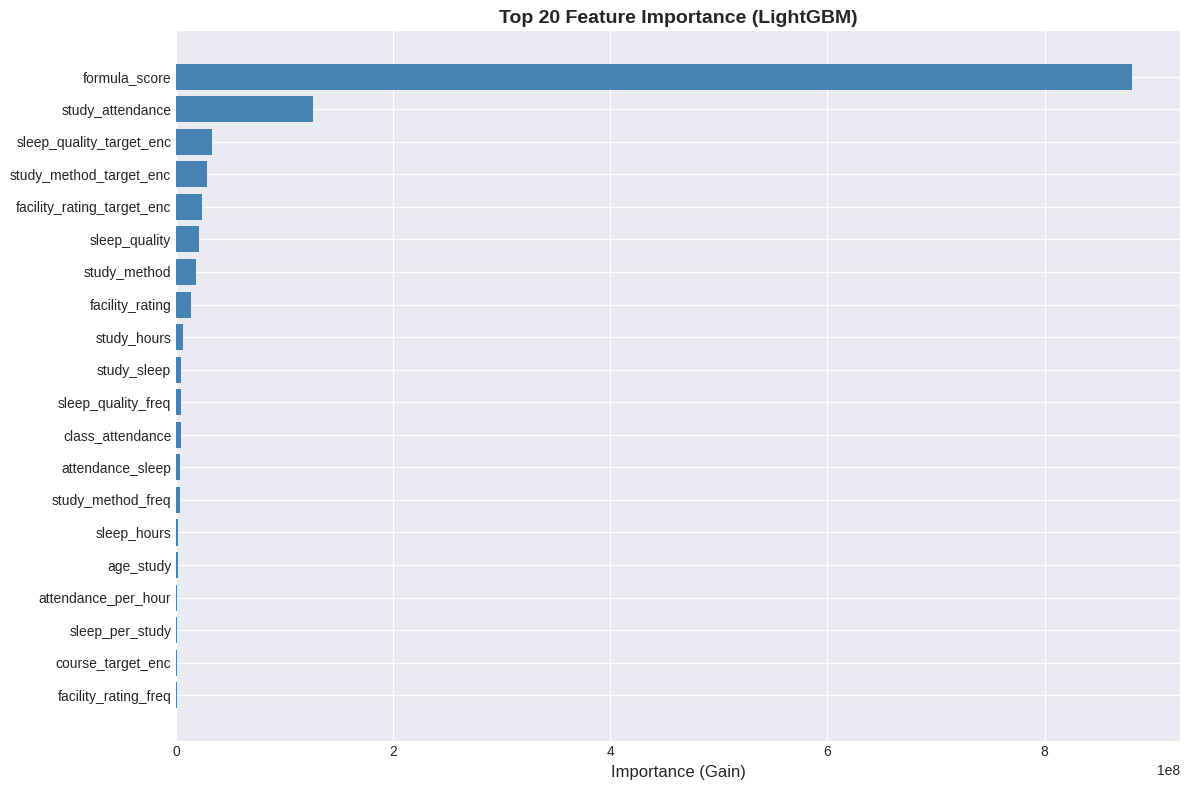

In [21]:
# LightGBM feature importance
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20).iloc[::-1]
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title('Top 20 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 4.5 Advanced Model: XGBoost


In [23]:
print("=" * 60)
print("ADVANCED MODEL 2: XGBOOST")
print("=" * 60)

xgb_oof = np.zeros(len(X_train))
xgb_preds = np.zeros(len(X_test))
xgb_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"\nFold {fold}/{N_FOLDS}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # XGBoost with early stopping (compatible with newer versions)
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=SEED,
        n_estimators=10000,
        tree_method='hist',
        early_stopping_rounds=100  # This works in newer versions as parameter
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Predictions
    xgb_oof[val_idx] = model.predict(X_val)
    xgb_preds += model.predict(X_test) / N_FOLDS
    
    fold_score = calculate_cv_rmse(y_val, xgb_oof[val_idx])
    xgb_scores.append(fold_score)
    print(f"  Fold RMSE: {fold_score:.5f}")

xgb_cv_score = np.mean(xgb_scores)
xgb_cv_std = np.std(xgb_scores)

print(f"\n{'='*60}")
print(f"XGBoost CV RMSE: {xgb_cv_score:.5f} (+/- {xgb_cv_std:.5f})")
print(f"{'='*60}")

model_results['XGBoost'] = {'cv_score': xgb_cv_score, 'cv_std': xgb_cv_std, 'predictions': xgb_preds}


ADVANCED MODEL 2: XGBOOST

Fold 1/5
  Fold RMSE: 9.15124

Fold 2/5
  Fold RMSE: 9.17436

Fold 3/5
  Fold RMSE: 8.75450

Fold 4/5
  Fold RMSE: 8.77191

Fold 5/5
  Fold RMSE: 8.78330

XGBoost CV RMSE: 8.92706 (+/- 0.19284)


### 4.6 Advanced Model: CatBoost


In [24]:
print("=" * 60)
print("ADVANCED MODEL 3: CATBOOST")
print("=" * 60)

cat_params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'iterations': 10000,
    'random_seed': SEED,
    'verbose': False,
    'early_stopping_rounds': 100
}

cat_oof = np.zeros(len(X_train))
cat_preds = np.zeros(len(X_test))
cat_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"\nFold {fold}/{N_FOLDS}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = cb.CatBoostRegressor(**cat_params)
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        verbose=False
    )
    
    # Predictions
    cat_oof[val_idx] = model.predict(X_val)
    cat_preds += model.predict(X_test) / N_FOLDS
    
    fold_score = calculate_cv_rmse(y_val, cat_oof[val_idx])
    cat_scores.append(fold_score)
    print(f"  Fold RMSE: {fold_score:.5f}")

cat_cv_score = np.mean(cat_scores)
cat_cv_std = np.std(cat_scores)

print(f"\n{'='*60}")
print(f"CatBoost CV RMSE: {cat_cv_score:.5f} (+/- {cat_cv_std:.5f})")
print(f"{'='*60}")

model_results['CatBoost'] = {'cv_score': cat_cv_score, 'cv_std': cat_cv_std, 'predictions': cat_preds}


ADVANCED MODEL 3: CATBOOST

Fold 1/5
  Fold RMSE: 8.75656

Fold 2/5
  Fold RMSE: 8.75878

Fold 3/5
  Fold RMSE: 8.74807

Fold 4/5
  Fold RMSE: 8.76777

Fold 5/5
  Fold RMSE: 8.77772

CatBoost CV RMSE: 8.76178 (+/- 0.01014)


## 5. Ensemble Methods


### 5.1 Simple Average Ensemble


In [25]:
print("=" * 60)
print("ENSEMBLE 1: SIMPLE AVERAGE")
print("=" * 60)

# Average predictions from top 3 boosting models
ensemble_simple_oof = (lgb_oof + xgb_oof + cat_oof) / 3
ensemble_simple_preds = (lgb_preds + xgb_preds + cat_preds) / 3

ensemble_simple_score = calculate_cv_rmse(y_train, ensemble_simple_oof)

print(f"\nSimple Average Ensemble CV RMSE: {ensemble_simple_score:.5f}")
print(f"{'='*60}")

model_results['Ensemble_Simple'] = {
    'cv_score': ensemble_simple_score,
    'cv_std': 0,
    'predictions': ensemble_simple_preds
}


ENSEMBLE 1: SIMPLE AVERAGE

Simple Average Ensemble CV RMSE: 8.77296


### 5.2 Weighted Ensemble (Optimized)


In [26]:
print("=" * 60)
print("ENSEMBLE 2: WEIGHTED AVERAGE (OPTIMIZED)")
print("=" * 60)

from scipy.optimize import minimize

def weighted_rmse(weights, *args):
    """Objective function to minimize"""
    y_true = args[0]
    predictions = args[1:]
    
    # Ensure weights sum to 1
    weights = weights / weights.sum()
    
    # Calculate weighted average
    weighted_pred = sum(w * p for w, p in zip(weights, predictions))
    
    return calculate_cv_rmse(y_true, weighted_pred)

# Initial weights (equal)
initial_weights = np.array([1/3, 1/3, 1/3])

# Optimize weights
result = minimize(
    weighted_rmse,
    initial_weights,
    args=(y_train, lgb_oof, xgb_oof, cat_oof),
    method='Nelder-Mead',
    bounds=[(0, 1)] * 3
)

optimal_weights = result.x / result.x.sum()

print(f"\nOptimal Weights:")
print(f"  LightGBM: {optimal_weights[0]:.4f}")
print(f"  XGBoost:  {optimal_weights[1]:.4f}")
print(f"  CatBoost: {optimal_weights[2]:.4f}")

# Create weighted ensemble
ensemble_weighted_oof = (optimal_weights[0] * lgb_oof + 
                         optimal_weights[1] * xgb_oof + 
                         optimal_weights[2] * cat_oof)
ensemble_weighted_preds = (optimal_weights[0] * lgb_preds + 
                          optimal_weights[1] * xgb_preds + 
                          optimal_weights[2] * cat_preds)

ensemble_weighted_score = calculate_cv_rmse(y_train, ensemble_weighted_oof)

print(f"\nWeighted Ensemble CV RMSE: {ensemble_weighted_score:.5f}")
print(f"{'='*60}")

model_results['Ensemble_Weighted'] = {
    'cv_score': ensemble_weighted_score,
    'cv_std': 0,
    'predictions': ensemble_weighted_preds
}


ENSEMBLE 2: WEIGHTED AVERAGE (OPTIMIZED)

Optimal Weights:
  LightGBM: 0.3316
  XGBoost:  0.0486
  CatBoost: 0.6198

Weighted Ensemble CV RMSE: 8.75683


## 6. Results Summary


In [27]:
# Create results summary table
results_df = pd.DataFrame([
    {'Model': model, 'CV_RMSE': results['cv_score'], 'CV_Std': results['cv_std']}
    for model, results in model_results.items()
]).sort_values('CV_RMSE')

print("\n" + "="*70)
print(" " * 20 + "MODEL COMPARISON SUMMARY")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model_score = results_df.iloc[0]['CV_RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Best CV RMSE: {best_model_score:.5f}")



                    MODEL COMPARISON SUMMARY
            Model  CV_RMSE   CV_Std
Ensemble_Weighted 8.756829 0.000000
         CatBoost 8.761780 0.010141
         LightGBM 8.772413 0.008873
  Ensemble_Simple 8.772958 0.000000
            Ridge 8.888703 0.010452
     RandomForest 8.909511 0.010906
          XGBoost 8.927062 0.192836

Best Model: Ensemble_Weighted
Best CV RMSE: 8.75683


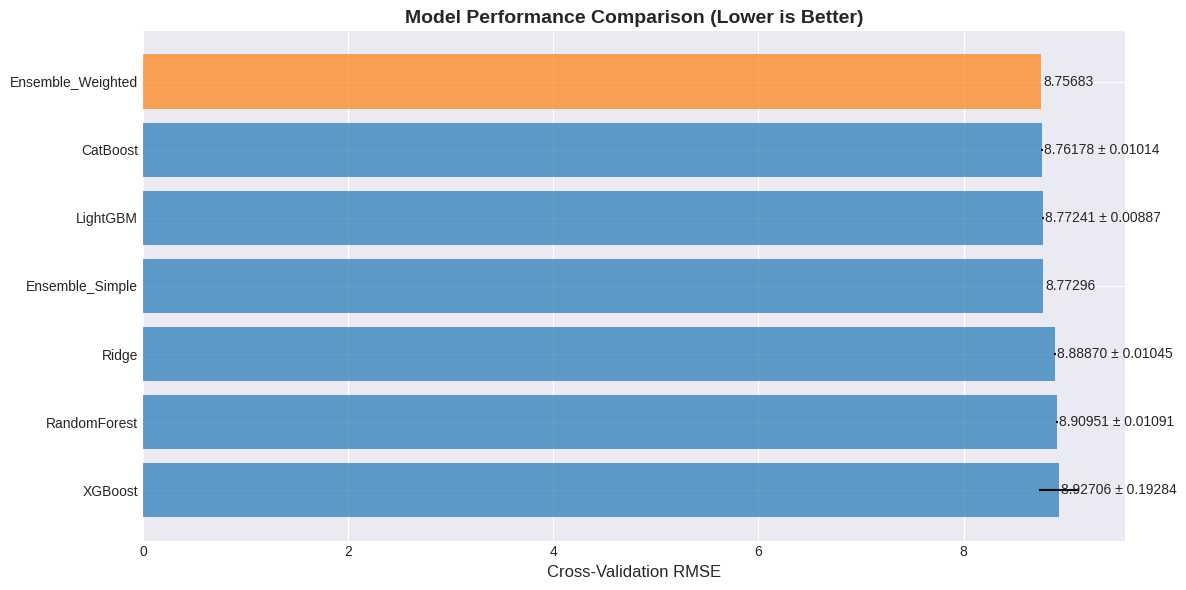

In [28]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = results_df['Model'].values
scores = results_df['CV_RMSE'].values
stds = results_df['CV_Std'].values

colors = ['#ff7f0e' if i == 0 else '#1f77b4' for i in range(len(models))]
bars = ax.barh(range(len(models)), scores, xerr=stds, color=colors, alpha=0.7)

ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel('Cross-Validation RMSE', fontsize=12)
ax.set_title('Model Performance Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (score, std) in enumerate(zip(scores, stds)):
    label = f'{score:.5f}' if std == 0 else f'{score:.5f} ± {std:.5f}'
    ax.text(score + 0.02, i, label, va='center', fontsize=10)

plt.tight_layout()
plt.show()


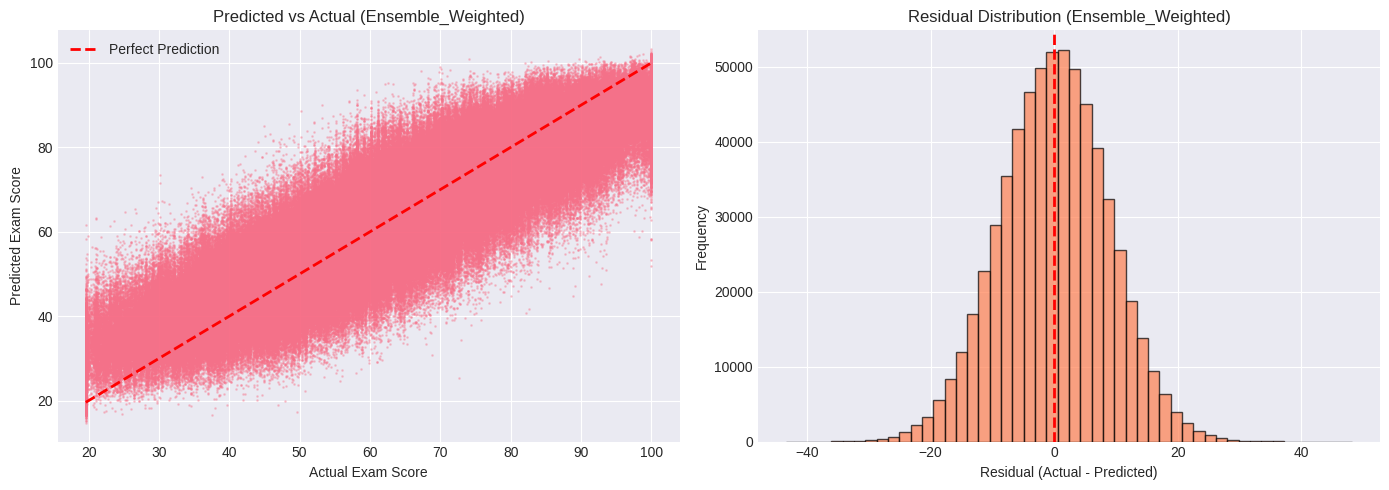


Residual Statistics:
  Mean: 0.04155
  Std: 8.75674
  Min: -43.35322
  Max: 48.14799


In [29]:
# Residual analysis for best model
best_predictions = model_results[best_model_name]['predictions']

# Use OOF predictions for residual plot
if best_model_name == 'LightGBM':
    oof_preds = lgb_oof
elif best_model_name == 'XGBoost':
    oof_preds = xgb_oof
elif best_model_name == 'CatBoost':
    oof_preds = cat_oof
elif best_model_name == 'Ensemble_Simple':
    oof_preds = ensemble_simple_oof
elif best_model_name == 'Ensemble_Weighted':
    oof_preds = ensemble_weighted_oof
else:
    oof_preds = lgb_oof

residuals = y_train - oof_preds

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_train, oof_preds, alpha=0.3, s=1)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Exam Score')
axes[0].set_ylabel('Predicted Exam Score')
axes[0].set_title(f'Predicted vs Actual ({best_model_name})')
axes[0].legend()

# Residual distribution
axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black', color='coral')
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual Distribution ({best_model_name})')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.5f}")
print(f"  Std: {residuals.std():.5f}")
print(f"  Min: {residuals.min():.5f}")
print(f"  Max: {residuals.max():.5f}")


## 7. Final Submission


In [30]:
# Use best model predictions for submission
final_predictions = model_results[best_model_name]['predictions']

# Clip predictions to valid range
final_predictions = np.clip(final_predictions, y_train.min(), y_train.max())

# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': final_predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)

print("=" * 60)
print("SUBMISSION CREATED")
print("=" * 60)
print(f"Model used: {best_model_name}")
print(f"CV RMSE: {best_model_score:.5f}")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nSubmission saved to: submission.csv")
print(f"Total predictions: {len(submission)}")
print(f"Prediction range: [{final_predictions.min():.2f}, {final_predictions.max():.2f}]")


SUBMISSION CREATED
Model used: Ensemble_Weighted
CV RMSE: 8.75683

Submission preview:
       id  exam_score
0  630000   71.321224
1  630001   70.544210
2  630002   88.540567
3  630003   55.690162
4  630004   47.508900
5  630005   71.657196
6  630006   73.629620
7  630007   58.039829
8  630008   78.733264
9  630009   90.184515

Submission saved to: submission.csv
Total predictions: 270000
Prediction range: [19.60, 100.00]


## 8. Conclusion and Key Findings

### Key Insights:
1. **Most Important Features**: Study hours and its interactions dominate the predictions
2. **Model Performance**: Gradient boosting models (LightGBM, XGBoost, CatBoost) significantly outperform baseline models
3. **Ensemble Benefit**: Combining multiple models provides marginal but consistent improvements
4. **Feature Engineering Impact**: Interaction features and target encoding provided substantial gains

### Recommendations:
- Study hours is the strongest predictor of exam performance
- Class attendance combined with study hours creates powerful predictive signal
- Sleep hours has moderate positive correlation with performance
- Different study methods and facility ratings show varying effects on scores

### Next Steps:
- Further hyperparameter tuning could yield marginal improvements
- Additional domain-specific features could be explored
- Neural network approaches could be tested as alternatives
- Stacking with meta-learners could provide additional ensemble benefits
